In [1]:
%matplotlib inline

import Bayesian_Particle_Tracking
from Bayesian_Particle_Tracking import model
from Bayesian_Particle_Tracking.model import log_likelihood, log_posterior, log_prior, diffusion
from Bayesian_Particle_Tracking import io
from Bayesian_Particle_Tracking.prior import JeffreysPrior, UniformPrior
from Bayesian_Particle_Tracking.printable import Printable
from Bayesian_Particle_Tracking import generate_data
from Bayesian_Particle_Tracking.generate_data import data_generation, generator
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Testing np.diff()

For some reason np.diff() seems to be pretty slow compared to copying an array twice (offset by one) and subtracting the copies from each other.

In [12]:
home_dir = "/Users/alanzhou/Documents/Physics_201/final_project/Bayesian-Particle-Tracking/"
data = np.load(home_dir + 'test_data.npy')
new_data = diffusion(data)

def test_function(diffusion_object):
    data = diffusion_object.data
    point_before = data[:len(data)-1]
    x_before, y_before, z_before = point_before[:,0], point_before[:,1], point_before[:,2]
    data_points = data[1:]
    x_data, y_data, z_data = data_points[:,0], data_points[:,1], data_points[:,2]
    distance = np.sqrt((x_before-x_data)**2+(y_before-y_data)**2+(z_before-z_data)**2)
    return(distance)

%timeit test_function(new_data)

The slowest run took 5.93 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 17 µs per loop


In [3]:
def new_function(diffusion_object):
    xyz = diffusion_object.data
    data = np.array((xyz[:,0], xyz[:,1], xyz[:,2])).T
    distance = np.sqrt(np.sum(np.diff(data, axis = 0)**2,axis = 1))
    return(distance)

%timeit new_function(new_data)

The slowest run took 8.16 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 29.2 µs per loop


In [4]:
test_array = np.array(np.arange(0,10))
test_array[5] = 20
%timeit np.diff(test_array)
np.diff(test_array)

The slowest run took 6.85 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 3.65 µs per loop


array([  1,   1,   1,   1,  16, -14,   1,   1,   1])

In [5]:
def diff(data):
    point_before = data[:len(data)-1]
    data_points = data[1:]
    distance = data_points-point_before
    return distance

%timeit diff(test_array)
diff(test_array)

The slowest run took 18.51 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 1.19 µs per loop


array([  1,   1,   1,   1,  16, -14,   1,   1,   1])

### Testing diffusion class and log_likelihood() speed

It seems that putting that the location of the displacement function doesn't really significantly impact speed

In [6]:
home_dir = "/Users/alanzhou/Documents/Physics_201/final_project/Bayesian-Particle-Tracking/"
data = np.load(home_dir + 'test_data.npy')

testD = 2e-10

In [7]:
class diffusion1(Printable):
    '''
    Contains data and relevent parameters for a 3-D Diffusion Process

    Attributes
    ----------
    data: size 3 x n array
        positional data input in cartesian coordinates (x,y,z)
    sigma: nonzero float
        specifies measurement uncertainty on measurement of particle position
    n : integer
        number of steps taken in diffusion process
    position: length 3 listlike
        initial position
    nwalkers: integer
        number of particles being tracked. TO BE IMPLEMENTED
    '''
    def __init__(self, data, nwalkers = 1):
        self.data = data
        self.n = len(data)
        self.initial_position = data[0]
        self.x = data[:,0]
        self.y = data[:,1]
        self.z = data[:,2]
        self.sigma = data[:,3]
    
    #Allows translation of the object
    def translate(self, offset):
        return diffusion(np.array((self.x+offset, self.y+offset, self.z+offset, self.sigma)).T)
    
    def displacement(self):
        data = self.data
        point_before = data[:len(data)-1]
        x_before, y_before, z_before = point_before[:,0], point_before[:,1], point_before[:,2]
        data_points = data[1:]
        x_data, y_data, z_data = data_points[:,0], data_points[:,1], data_points[:,2]
        distance = np.sqrt((x_before-x_data)**2+(y_before-y_data)**2+(z_before-z_data)**2)
        return(distance)


def log_likelihood1(D, diffusion_object, tau = 1):
    """
    Likelihood function for 3D diffusion process of a single particle.

    Parameter:
        diffusion_object: contains the following:
            data: positional data: assumes data is in the form of column vectors (traj_x,traj_y,traj_z)
                where traj_x,traj_y,traj_z are the coordinate positions of the particle
            sigma: variance on positional data; we assume the uncertainty is Gaussian; true dependency will be from raw image data
        D: diffusion coefficient;
    """

    data = diffusion_object.data
    sigma = diffusion_object.sigma
    distance = diffusion_object.displacement()
    
    #Delete the first element of the sigma array to match array sizes
    sigma = sigma[:len(sigma)-1]
    
    #TODO: rename
    sigma1 = np.sqrt(6*D*tau)

    #Should be correct with the correct log properties
    result = (-len(data)/2)*np.log(2*np.pi)+np.sum(np.log((sigma1**2+sigma**2)**(-1/2)))+np.sum(-((distance)**2)/(2*(sigma1**2+sigma**2)))
    return result

diffusion_data = diffusion1(data)

In [8]:
%timeit log_likelihood1(testD, diffusion_data)

The slowest run took 4.08 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 84.9 µs per loop


In [9]:
%timeit diffusion_data = diffusion1(data)

The slowest run took 4.62 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.19 µs per loop


In [10]:
class diffusion(Printable):
    '''
    Contains data and relevent parameters for a 3-D Diffusion Process

    Attributes
    ----------
    data: size 3 x n array
        positional data input in cartesian coordinates (x,y,z)
    sigma: nonzero float
        specifies measurement uncertainty on measurement of particle position
    n : integer
        number of steps taken in diffusion process
    position: length 3 listlike
        initial position
    nwalkers: integer
        number of particles being tracked. TO BE IMPLEMENTED
    '''
    def __init__(self, data, nwalkers = 1):
        self.data = data
        self.n = len(data)
        self.initial_position = data[0]
        self.x = data[:,0]
        self.y = data[:,1]
        self.z = data[:,2]
        self.sigma = data[:,3]
    
    #Allows translation of the object
    def translate(self, offset):
        return diffusion(np.array((self.x+offset, self.y+offset, self.z+offset, self.sigma)).T)

def log_likelihood(D, diffusion_object, tau = 1):
    """
    Likelihood function for 3D diffusion process of a single particle.

    Parameter:
        diffusion_object: contains the following:
            data: positional data: assumes data is in the form of column vectors (traj_x,traj_y,traj_z)
                where traj_x,traj_y,traj_z are the coordinate positions of the particle
            sigma: variance on positional data; we assume the uncertainty is Gaussian; true dependency will be from raw image data
        D: diffusion coefficient;
    """

    data = diffusion_object.data
    sigma = diffusion_object.sigma
    
    #Delete the first element of the sigma array to match array sizes
    sigma = sigma[:len(sigma)-1]
    
    #TODO: rename
    sigma1 = np.sqrt(6*D*tau)
    
    #This should give us the delta x_{i,i-1}. 
    #point_before is the data list minus the last element.
    #data_points is the data list minus the first element.
    #distance is array containing the displacements between two consecutive points in the series.
    #TODO: np.diff seems to run a lot slower than the following 4 lines:

    point_before = data[:len(data)-1]
    x_before, y_before, z_before = point_before[:,0], point_before[:,1], point_before[:,2]
    data_points = data[1:]
    x_data, y_data, z_data = data_points[:,0], data_points[:,1], data_points[:,2]

    distance = np.sqrt((x_before-x_data)**2+(y_before-y_data)**2+(z_before-z_data)**2)

    #Should be correct with the correct log properties
    result = (-len(data)/2)*np.log(2*np.pi)+np.sum(np.log((sigma1**2+sigma**2)**(-1/2)))+np.sum(-((distance)**2)/(2*(sigma1**2+sigma**2)))
    return result

diffusion_data = diffusion(data)

In [11]:
%timeit log_likelihood(testD, diffusion_data)

10000 loops, best of 3: 85 µs per loop


In [12]:
%timeit diffusion_data = diffusion(data)

The slowest run took 4.14 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.54 µs per loop


### Raising exceptions

Figuring out

In [25]:
def exception_test(lala):
    if isinstance(lala, int):
        print('not an int')
    else:
        print('is an int')

In [26]:
exception_test('hi')
exception_test(10)
exception_test([0,0])

is an int
not an int
is an int


In [34]:
def exception_test2(test_value):
    if not isinstance(test_value, int):
        raise ValueError('is not an int')

In [35]:
exception_test2('lala')


ValueError: is not an int

In [36]:
test_string = 'lalala'

print('%s is not' %test_string)

lalala is not


Test to allow input dimensions for log_likelihood

In [37]:
from numpy.random import normal

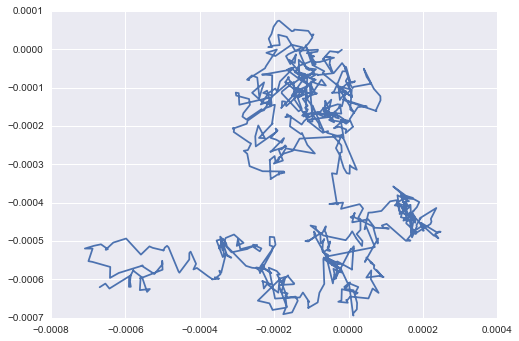

In [34]:
test_data = generator(1000,10**(-8),10**(-4),10**(-8),[0,0,0])
test_data = diffusion(test_data)
plt.plot(test_data.x, test_data.y)

In [32]:
maxindex = [np.max(logposteriorD)==logposteriorD]
np.argmax(logposteriorD)
D[np.argmax(logposteriorD)]

2.196717336104949e-10

2.21934317634e-10
2.21983381722e-10


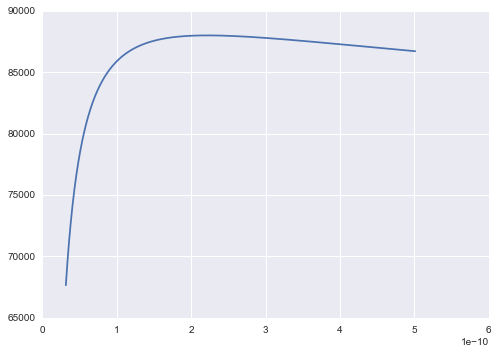

In [40]:
test_data = generator(10000,1e-30,10**(-4),10**(-8),[0,0,0])
test_data = diffusion(test_data)
D = np.logspace(-10.5, -9.3, 100000)
logpriorD = np.array(list(map(log_prior,D)))
loglikelihoodD = np.array(list(map(lambda d: log_likelihood(d, test_data), D)))
logposteriorD = logpriorD + loglikelihoodD
plt.plot(D, logposteriorD)
maxindex = [np.max(logposteriorD)==logposteriorD]
np.argmax(logposteriorD)
print(D[np.argmax(logposteriorD)])
print(D[np.argmax(loglikelihoodD)])

In [52]:
estimation_index = [loglikelihoodD > (loglikelihoodD.max() - 0.5)]

1

In [30]:
estimation_index = [D > log_likeli]

88055.984500000006

2.23714687116e-10


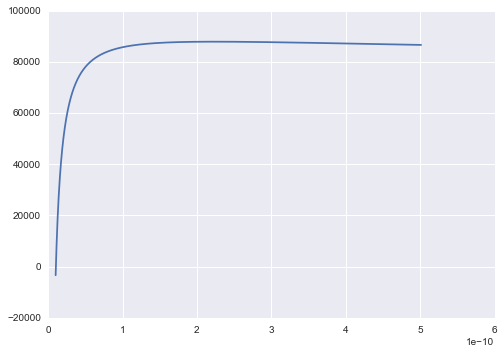

In [33]:
test_data = generator(10000,1e-30,10**(-4),10**(-8),[0,0,0])
test_data = diffusion(test_data)
D = np.logspace(-11, -9.3, 100000)
logpriorD = np.array(list(map(log_prior,D)))
loglikelihoodD = np.array(list(map(lambda d: log_likelihood(d, test_data), D)))
logposteriorD = logpriorD + loglikelihoodD
plt.plot(D, logposteriorD)
maxindex = [np.max(logposteriorD)==logposteriorD]
np.argmax(logposteriorD)
print(D[np.argmax(logposteriorD)])

In [ ]:
rnoise = normal(0, sigma, nsteps)
thetanoise = uniform(0,np.pi,nsteps)
phinoise = uniform(0,2*np.pi,nsteps)
    #Spherical to Cartesian Coordinates
x_noise = rnoise*np.sin(thetanoise)*np.cos(phinoise)
y_noise = rnoise*np.sin(thetanoise)*np.sin(phinoise)
z_noise = rnoise*np.cos(thetanoise)